## Imports


In [1]:
import json
import os
import sys
from pathlib import Path
import pandas as pd
from requests import HTTPError

In [2]:
from mvg import MVG

In [3]:
#ENDPOINT = "https://api.beta.multiviz.com"
ENDPOINT = "http://127.0.0.1:8000"
# Replace by your own Token
VALID_TOKEN = os.environ['TEST_TOKEN']

In [4]:
session = MVG(ENDPOINT, VALID_TOKEN)

We now check if the server is alive.
The hello message contains the API version:

In [5]:
hello_message = json.dumps(session.say_hello())
hello_message


'{"api": {"name": "MultiViz Engine API", "version": "0.0.0-dev0", "swagger": "http://127.0.0.1:8000/docs"}}'

Checking MVG version

In [6]:
hello_message = json.dumps(session.check_version())
hello_message

Using developer API: 0.0.0-dev0. You must confirm compatibility yourself.


'{"api_version": "0.0.0-dev0", "mvg_highest_tested_version": "0.1.15", "mvg_version": "0.8.0"}'

## Sources and Measurements

Before we begin, we will ensure there are no previously existing sources and if there are, we will delete them.

In [7]:
sources = session.list_sources()

print("Retrieved sources")
for src in sources:
    print(src)
    print(f"Deleting {src['source_id']}")
    #session.delete_source(src['source_id'])


Retrieved sources
{'source_id': 'u0001', 'meta': {'assetId': 'assetA', 'measPoint': 'mloc01', 'location': 'paris'}, 'properties': {'data_class': 'waveform'}}
Deleting u0001


In [8]:
# Path to the source folder
REF_DB_PATH = Path.cwd() / "va-data-charlie" / "charlieDb" / "acc"
REF_DB_PATH
# Definition of the source_id
SOURCE_ID = "u0001"
SOURCE_ID

'u0001'

In [9]:
# Create source
src_path = REF_DB_PATH / SOURCE_ID
meta_filename = src_path / "meta.json"
with open(meta_filename, "r") as json_file:
    meta = json.load(json_file)
session.create_source(SOURCE_ID, meta)
session.get_source(SOURCE_ID)

HTTPError: 409 Client Error: Conflict for url: http://127.0.0.1:8000/sources/

List sources

In [10]:
sources = session.list_sources()
sources

[{'source_id': 'u0001',
  'meta': {'assetId': 'assetA', 'measPoint': 'mloc01', 'location': 'paris'},
  'properties': {'data_class': 'waveform'}}]

In [12]:
# meas is a list of timestamps representing the measurements in our repo
meas = {f.split(".")[0] for f in os.listdir(src_path)}
# We remove the "meta" file from this list
meas.remove("meta")


In [13]:
# We iterate over all of elements in this list
for m in meas:

    # raw data per measurement
    TS_MEAS = str(m) + ".csv"  # filename
    TS_MEAS = REF_DB_PATH / SOURCE_ID / TS_MEAS  # path to file
    ts_df = pd.read_csv(TS_MEAS, names=['acc'])  # read csv into df
    accs = ts_df.iloc[:, 0].tolist()  # convert to list
    print(f"Read {len(accs)} samples")

    # meta information file per measurement
    TS_META = str(m) + ".json"  # filename
    TS_META = REF_DB_PATH / SOURCE_ID / TS_META  # path
    with open(TS_META, "r") as json_file:  # read json
        meas_info = json.load(json_file)  # into dict
    print(f"Read meta:{meas_info}")

    # get duration and other meta info
    duration = meas_info['duration']
    meta_info = meas_info['meta']

    # Upload measurements
    print(f"Uploading {TS_MEAS}")
    try:
        session.create_measurement(sid=SOURCE_ID,
                                   duration=duration,
                                   timestamp=m,
                                   data=accs,
                                   meta=meta_info)
    except HTTPError as exc:
        print(exc)


Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading C:\Users\Sergio\Documents\GitHub\mvg\docs\source\content\examples\va-data-charlie\charlieDb\acc\u0001\1571482860.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading C:\Users\Sergio\Documents\GitHub\mvg\docs\source\content\examples\va-data-charlie\charlieDb\acc\u0001\1572350460.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading C:\Users\Sergio\Documents\GitHub\mvg\docs\source\content\examples\va-data-charlie\charlieDb\acc\u0001\1572523260.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading C:\Users\Sergio\Documents\GitHub\mvg\docs\source\content\examples\va-data-charlie\charlieDb\acc\u0001\1571137260.csv
Read 40000 samples
Read meta:{'duration': 2.8672073400507907, 'meta': {}}
Uploading C:\Users\Sergio\Documents\GitHub\mvg\docs\source\content\examples\va-data-charlie\charlieDb\acc\u0001\1573905660

Check if we actually created the measurements by reading them.

In [11]:
m = session.list_measurements(SOURCE_ID)
print(f"Read {len(m)} stored measurements")


Read 50 stored measurements


## Analysis

We begin by listing all the features available in the service.

In [12]:
available_features = session.supported_features()
available_features

{'RMS': '1.0.0', 'ModeId': '0.1.1', 'BlackSheep': '1.0.0', 'KPIDemo': '1.0.0'}

Request RMS analysis

In [13]:
RMS_u0001 = session.request_analysis(SOURCE_ID, 'RMS')
RMS_u0001

{'request_id': '40c9c61f738869d68132ab1d7d32dd1e', 'request_status': 'queued'}

In [15]:
REQUEST_ID_RMS_u0001 = RMS_u0001['request_id']
status = session.get_analysis_status(REQUEST_ID_RMS_u0001)
print(f"RMS Analysis: {status}")


RMS Analysis: successful


In [16]:
rms_results = session.get_analysis_results(request_id=REQUEST_ID_RMS_u0001)

rms_results.keys()


dict_keys(['status', 'request_id', 'feature', 'results', 'inputs', 'error_info', 'debug_info'])

### Visualization

In [17]:
from mvg import analysis_classes

In [18]:
rms_results_parsed = analysis_classes.parse_results(rms_results)

From here, we can call these results into a Pandas dataframe.

In [19]:
df_rms = rms_results_parsed.to_df()
df_rms.head()


,timestamps,rms,rms_dc,dc,utilization
0,1570186860,0.647086,0.662108,-0.140237,1
1,1570273260,0.647123,0.662183,-0.140420,1
2,1570359660,0.646619,0.661652,-0.140239,1
3,1570446060,0.646873,0.661923,-0.140347,1
4,1570532460,0.646643,0.661714,-0.140423,1


In [20]:
rms_results_parsed.summary()


=== RMS ===
request_id 40c9c61f738869d68132ab1d7d32dd1e
from 1570186860 to 1574424060

+-------+--------------+------------+------------+------------+---------------+
|       |   timestamps |        rms |     rms_dc |         dc |   utilization |
|-------+--------------+------------+------------+------------+---------------|
| count | 50           | 50         | 50         | 50         |            50 |
| mean  |  1.57231e+09 |  0.611691  |  0.623692  | -0.120874  |             1 |
| std   |  1.26105e+06 |  0.0565414 |  0.0563824 |  0.0141936 |             0 |
| min   |  1.57019e+09 |  0.484564  |  0.497987  | -0.140524  |             1 |
| 25%   |  1.57125e+09 |  0.627912  |  0.637381  | -0.140196  |             1 |
| 50%   |  1.57231e+09 |  0.628307  |  0.6378    | -0.112316  |             1 |
| 75%   |  1.57337e+09 |  0.64684   |  0.661892  | -0.10966   |             1 |
| max   |  1.57442e+09 |  0.647694  |  0.662754  | -0.109065  |             1 |
+-------+--------------+---------

,timestamps,rms,rms_dc,dc,utilization
count,5.000000e+01,50.000000,50.000000,50.000000,50.0
mean,1.572306e+09,0.611691,0.623692,-0.120874,1.0
std,1.261051e+06,0.056541,0.056382,0.014194,0.0
min,1.570187e+09,0.484564,0.497987,-0.140524,1.0
25%,1.571245e+09,0.627912,0.637381,-0.140196,1.0
50%,1.572307e+09,0.628307,0.637800,-0.112316,1.0
75%,1.573366e+09,0.646840,0.661892,-0.109660,1.0
max,1.574424e+09,0.647694,0.662754,-0.109065,1.0


Finally, we can generate a plot that displays these results.

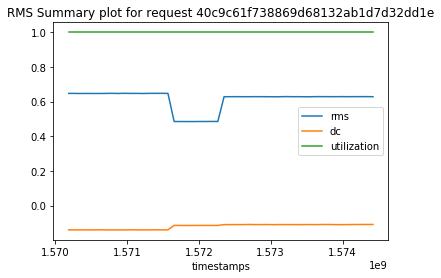

''

In [21]:
rms_results_parsed.plot()

### KPIDemo

Request KPIDemo analysis

In [22]:
KPI_u0001 = session.request_analysis(SOURCE_ID, 'KPIDemo')
KPI_u0001

{'request_id': 'ddabda66bf6c74a5d9910595d52abd89', 'request_status': 'queued'}

In [23]:
REQUEST_ID_KPI_u0001 = KPI_u0001['request_id']
status = session.get_analysis_status(REQUEST_ID_KPI_u0001)
print(f"KPIDemo Analysis: {status}")


KPIDemo Analysis: successful


In [24]:
kpi_results = session.get_analysis_results(request_id=REQUEST_ID_KPI_u0001)

kpi_results.keys()


dict_keys(['status', 'request_id', 'feature', 'results', 'inputs', 'error_info', 'debug_info'])

### Visualization


In [25]:
kpi_results_parsed = analysis_classes.parse_results(kpi_results)

From here, we can call these results into a Pandas dataframe.

In [26]:
df_rms = kpi_results_parsed.to_df()
df_rms.head()


,rms,peak,peak2peak,variance,crest_factor,utilization,dc_component,timestamps
0,0.647086,2.686563,5.313293,0.418720,4.151786,1,-0.140237,1570186860
1,0.647123,2.691750,5.367004,0.418769,4.159563,1,-0.140420,1570273260
2,0.646619,2.715251,5.414856,0.418116,4.199152,1,-0.140239,1570359660
3,0.646873,2.685147,5.351562,0.418445,4.150966,1,-0.140347,1570446060
4,0.646643,2.726605,5.395325,0.418147,4.216556,1,-0.140423,1570532460


In [27]:
kpi_results_parsed.summary()


=== KPIDemo ===
request_id ddabda66bf6c74a5d9910595d52abd89
from 1570186860 to 1574424060

+-------+------------+-----------+-------------+------------+----------------+---------------+----------------+--------------+
|       |        rms |      peak |   peak2peak |   variance |   crest_factor |   utilization |   dc_component |   timestamps |
|-------+------------+-----------+-------------+------------+----------------+---------------+----------------+--------------|
| count | 50         | 50        |   50        | 50         |      50        |            50 |     50         | 50           |
| mean  |  0.611691  |  2.81764  |    5.40059  |  0.377299  |       4.62976  |             1 |     -0.120874  |  1.57231e+09 |
| std   |  0.0565414 |  0.278079 |    0.378225 |  0.0636172 |       0.333367 |             0 |      0.0141936 |  1.26105e+06 |
| min   |  0.484564  |  2.26056  |    4.55438  |  0.234802  |       4.12339  |             1 |     -0.140524  |  1.57019e+09 |
| 25%   |  0.627912 

,rms,peak,peak2peak,variance,crest_factor,utilization,dc_component,timestamps
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.0,50.000000,5.000000e+01
mean,0.611691,2.817641,5.400591,0.377299,4.629763,1.0,-0.120874,1.572306e+09
std,0.056541,0.278079,0.378225,0.063617,0.333367,0.0,0.014194,1.261051e+06
min,0.484564,2.260560,4.554382,0.234802,4.123387,1.0,-0.140524,1.570187e+09
25%,0.627912,2.683375,5.313644,0.394273,4.204021,1.0,-0.140196,1.571245e+09
50%,0.628307,2.849990,5.526337,0.394770,4.806408,1.0,-0.112316,1.572307e+09
75%,0.646840,3.066612,5.693771,0.418402,4.890653,1.0,-0.109660,1.573366e+09
max,0.647694,3.136087,5.796387,0.419507,4.992559,1.0,-0.109065,1.574424e+09


Finally, we can generate a plot that displays these results.

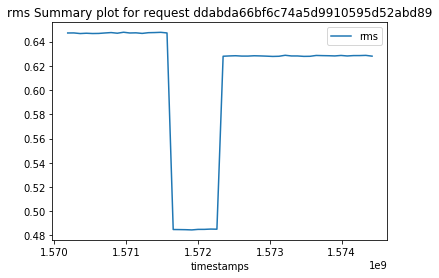

''

In [28]:
#["rms", "dc", "utilization"]
kpi_results_parsed.plot()

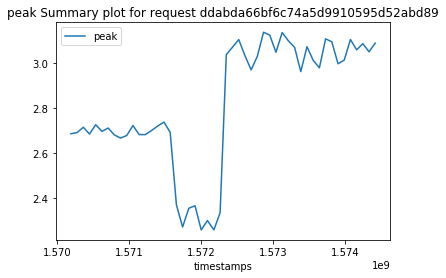

''

In [29]:
#["rms", "dc", "utilization"]
kpi_results_parsed.plot(kpi="peak")

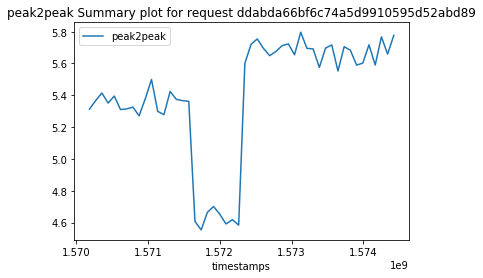

''

In [30]:
#["rms", "dc", "utilization"]
kpi_results_parsed.plot(kpi="peak2peak")

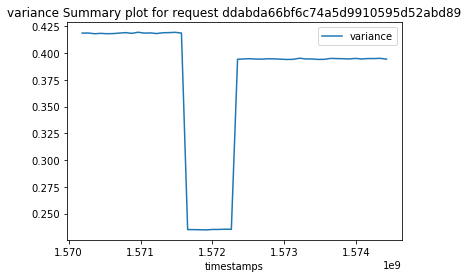

''

In [31]:
#["rms", "dc", "utilization"]
kpi_results_parsed.plot(kpi="variance")


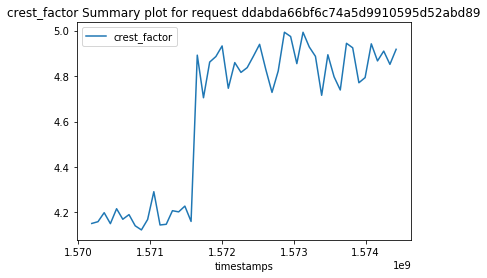

''

In [32]:
#["rms", "dc", "utilization"]
kpi_results_parsed.plot(kpi="crest_factor")

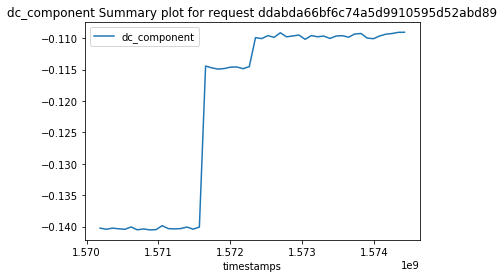

''

In [33]:
#["rms", "dc", "utilization"]
kpi_results_parsed.plot(kpi="dc_component")


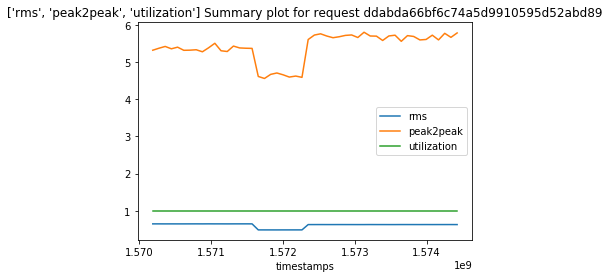

''

In [34]:
kpis = ["rms", "peak2peak", "utilization"]
kpi_results_parsed.plot(kpi=kpis)
